In [185]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import re
import string

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [186]:
df = pd.read_csv('datasets/billboard.zip')
df.head()

,date,year,title,simple_title,artist,main_artist,peak_pos,last_pos,weeks,rank,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
0,6/21/18,NaN,4th Dimension,NaN,Kanye West and Kid Cudi,NaN,42,0,1,42,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Error: Could not find lyrics.
1,6/21/18,NaN,All Girls Are The Same,NaN,Juice WRLD,NaN,41,49,5,41,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,NaN,All Mine,NaN,Kanye West,NaN,11,11,2,31,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
3,6/21/18,NaN,Alone,NaN,Halsey Featuring Big Sean & Stefflon Don,NaN,70,73,9,74,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Error: Could not find lyrics.
4,6/21/18,NaN,Babe,NaN,Sugarland Featuring Taylor Swift,NaN,72,0,2,95,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Error: Could not find lyrics.


In [187]:
df.shape

(7573, 31)

In [188]:
df = df[df['lyrics'].str.contains("Error: Could not find lyrics.") == False]

In [189]:
df.shape

(7228, 31)

In [190]:
df.head()

,date,year,title,simple_title,artist,main_artist,peak_pos,last_pos,weeks,rank,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,NaN,All Girls Are The Same,NaN,Juice WRLD,NaN,41,49,5,41,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,NaN,All Mine,NaN,Kanye West,NaN,11,11,2,31,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,NaN,Back To You,NaN,Selena Gomez,NaN,22,31,5,22,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,NaN,Be Careful,NaN,Cardi B,NaN,11,25,11,23,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,NaN,Beautiful Crazy,NaN,Luke Combs,NaN,58,77,4,93,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


In [191]:
cols = ['simple_title', 'main_artist', 'year', 'peak_pos', 'last_pos', 'weeks', 'rank', 'change', 'video_link', 'broad_genre']

In [192]:
df = df.drop(cols, axis=1)

In [193]:
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,[u'rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"[u'pop rap', u'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"[u'dance pop', u'pop', u'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"[u'pop', u'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"[u'contemporary country', u'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


genre_preprocess removes the unnecessary "u" from each list of genres.

In [194]:
def genre_preprocess(text : str) -> str:
    text = re.sub("u'", "'", text)
    return text

df['genre'] = df.genre.apply(genre_preprocess)
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,['rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"['pop rap', 'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"['dance pop', 'pop', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"['pop', 'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"['contemporary country', 'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


In [195]:
df.shape

(7228, 21)

In [196]:
def clean_lyrics(text):
    text = text.lower()
    text = text.encode('ascii', 'ignore').decode()
    stop_words = stopwords.words('english')
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\w*\d+\w*', '', text)
    text = re.sub('\s{2,}', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub(' s ', ' ', text)
    text = re.sub(' m ', ' ', text)
    return text

In [197]:
df['clean_lyrics'] = df.lyrics.apply(clean_lyrics)

In [198]:
text = " ".join(i for i in df.clean_lyrics)

In [199]:
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics,clean_lyrics
1,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,['rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are...",they re rotting brain love these hoes same i a...
2,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"['pop rap', 'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus...",yeah supermodel thick damn ass bustin bottom i...
5,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"['dance pop', 'pop', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...,took like shot thought could chase cold evenin...
7,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"['pop', 'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ...",yeah be careful careful careful me yeah look i...
8,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"['contemporary country', 'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...,day starts coffee and ends wine takes forever ...


In [200]:
df = df.reset_index(drop=True)
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics,clean_lyrics
0,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,['rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are...",they re rotting brain love these hoes same i a...
1,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"['pop rap', 'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus...",yeah supermodel thick damn ass bustin bottom i...
2,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"['dance pop', 'pop', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...,took like shot thought could chase cold evenin...
3,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"['pop', 'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ...",yeah be careful careful careful me yeah look i...
4,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"['contemporary country', 'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...,day starts coffee and ends wine takes forever ...


In [203]:
df.shape

(7228, 22)

In [204]:
df = df.drop_duplicates(subset='spotify_id')

In [205]:
df.shape

(6777, 22)

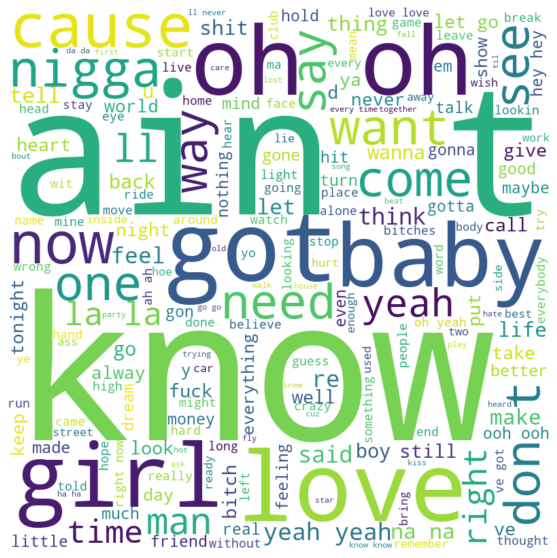

In [206]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

TF-IDF Vectorizer. Here I'm creating a TF-IDF matrix based on the "clean_lyrics" column that was created earlier.

In [207]:
tf_idf = TfidfVectorizer()
tf_idf_matrix = tf_idf.fit_transform(df['clean_lyrics'])
lyrics_df = pd.DataFrame(tf_idf_matrix.toarray())
tf_idf.get_feature_names_out()
print(tf_idf_matrix.shape)

(6777, 35141)


In [208]:
print(tf_idf_matrix[0])

  (0, 4930)	0.04152246764062008
  (0, 21259)	0.2181085860058776
  (0, 22486)	0.11126461018845976
  (0, 8031)	0.14168046445754962
  (0, 21084)	0.04492353526148891
  (0, 4984)	0.07987594479064472
  (0, 11079)	0.05626307697928164
  (0, 9465)	0.07296973671314179
  (0, 12717)	0.06305716574602435
  (0, 31355)	0.04443554846207945
  (0, 33779)	0.08215845261828515
  (0, 32033)	0.05864447682074551
  (0, 16902)	0.016655923223141696
  (0, 19463)	0.03178568095495615
  (0, 18049)	0.07059887356008236
  (0, 27943)	0.0940877245370863
  (0, 29472)	0.08956289837542093
  (0, 3540)	0.07670162951988528
  (0, 12723)	0.0604422498326103
  (0, 9260)	0.06559660493336711
  (0, 17784)	0.10099210344758407
  (0, 3763)	0.03835823760163885
  (0, 31464)	0.02819900300686821
  (0, 30501)	0.047102449758428866
  (0, 34538)	0.03201984854115911
  :	:
  (0, 13766)	0.0677134692590944
  (0, 3574)	0.05317302194126194
  (0, 34117)	0.03973726807813742
  (0, 18269)	0.1248903736328047
  (0, 27958)	0.05739453845815238
  (0, 12114)	0.

In [209]:
cos_sim = cosine_similarity(tf_idf_matrix)

This function returns the index numbers of the song that is being entered into the recommendation system. This is the song the user wants to find more of.

In [210]:
def get_index_spid(df, spotify_id : str):
    """This function takes in a dataframe and a spotify ID and returns the index of that song."""
    print(spotify_id.values)
    row_num = df[df['spotify_id'].isin(spotify_id.values)]
    print("Playlist User Enterd:")
    print(row_num[['title', 'artist', 'spotify_id']])
    # print(row_num['clean_lyrics'])

    user_playlist_song_ids = row_num['spotify_id']
    print(user_playlist_song_ids)

    user_playlist_lyrics = ' '.join(row_num['clean_lyrics'].tolist())
    print(user_playlist_lyrics)


    return user_playlist_song_ids, user_playlist_lyrics

This just test's the code to see if it works.

In [223]:
sp_ids = df['spotify_id']
user_playlist_song_ids, user_playlist_lyrics = get_index_spid(df=df, spotify_id=sp_ids.sample(n=7))



['1LkoYGxmYpO6QSEvY5C0Zl' '4IBF3hPcSLggvQGaafJvg4'
 '4qywl3iwOeIiCQR5cAakUz' '0nnxf8p851ZR49KFnGWVsB'
 '2tE8dp7Xvhx9bfqHfqs0GJ' '7lc5TciJbBz9Ko7iiYvCsK']
Playlist User Enterd:
                     title          artist              spotify_id
2584                  Over   blake shelton  2tE8dp7Xvhx9bfqHfqs0GJ
2833     Raise Your Weapon        deadmau5  4IBF3hPcSLggvQGaafJvg4
3014      Beautiful People     chris brown  7lc5TciJbBz9Ko7iiYvCsK
3314   Take Me Or Leave Me       glee cast  4qywl3iwOeIiCQR5cAakUz
4025  Say Hey (I Love You)  michael franti  0nnxf8p851ZR49KFnGWVsB
5193   Scotty Doesn't Know          lustra  1LkoYGxmYpO6QSEvY5C0Zl
2584    2tE8dp7Xvhx9bfqHfqs0GJ
2833    4IBF3hPcSLggvQGaafJvg4
3014    7lc5TciJbBz9Ko7iiYvCsK
3314    4qywl3iwOeIiCQR5cAakUz
4025    0nnxf8p851ZR49KFnGWVsB
5193    1LkoYGxmYpO6QSEvY5C0Zl
Name: spotify_id, dtype: object
could i would dare feed dreams starve fears if could light world we could sit watch burn we could fall asleep inside glow so tell gotta w

In [224]:
def generate_recommendations(user_playlist_song_ids, user_playlist_lyrics):
    clean_lyrics = df['clean_lyrics']

    vectorizer = TfidfVectorizer()

    tfidf_matrix = vectorizer.fit_transform(clean_lyrics)

    user_tfidf = vectorizer.transform([user_playlist_lyrics])

    cosine_similarities = cosine_similarity(user_tfidf, tfidf_matrix).flatten()

    song_indices = cosine_similarities.argsort()[::-1]

    recommended_songs = []
    for i in song_indices:
        if len(recommended_songs) == 5:
            break
        elif df.loc[i, 'spotify_id'] in user_playlist_song_ids:
            continue
        else:
            recommended_songs.append(df.loc[i, 'spotify_id'])

    return recommended_songs
    
        
    

In [225]:

recommendations = generate_recommendations(user_playlist_song_ids=user_playlist_song_ids, user_playlist_lyrics=user_playlist_lyrics)
song_details = df[df['spotify_id'].isin(recommendations)].drop_duplicates(subset='spotify_id')
print(song_details[['title', 'artist']])
print("Recommended Songs: ", recommendations)

                                                  title            artist
2597                                         Angel Eyes    love and theft
2771                                            4:00 AM     melanie fiona
3508  Hope She Cheats On You (With A Basketball Player)  marsha ambrosius
3736                                       Shut It Down           pitbull
4833                          G.N.O. (Girl's Night Out)       miley cyrus
Recommended Songs:  ['32sdJuk9CoZgSe9bTSyC98', '6r9uMZ7NBaMO1ovylcJZI4', '6eyd3UdMl5wek5jG8nHOqm', '3vMIAawCfJdR6A86JGqLc5', '158ERxdaPpcV23uj9EccXL']


This code returns the cosine similarity scores of all the songs. I've set it up so that it returns the most similar scores in descending order. That being the most similar are at the top and the least similar are at the bottom.

In [ ]:
score_series = pd.Series(cos_sim[row_number]).sort_values(ascending=False)

Returns the top five songs that are most similar to the song chosen.

In [95]:
top_5_indexes = list(score_series.iloc[1:6].index)

In [96]:
recommended_songs = []
for i in top_5_indexes:
    recommended_songs.append(list(df.index)[i])
print(recommended_songs)

[5730, 1957, 13, 6971, 3970]


In [97]:
def get_song_details(df, songs : list) -> list:
    song_rows = df.iloc[songs]
    return song_rows

get_song_details(df, songs=recommended_songs)


,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics,clean_lyrics
5730,1/22/05,So Cold,breaking benjamin,https://embed.spotify.com/?uri=spotify:track:3...,3xXKwkmkrpZmGpIof83xbE,"['alternative metal', 'nu metal', 'pop punk', ...",https://api.spotify.com/v1/audio-analysis/3xXK...,0.791,0.124,153.026,...,0.000112,4,0.481,0,273040,-5.456,0.287,0,Crowded streets are cleared away\nOne by one\n...,crowded streets cleared away one one hollow he...
1957,6/14/14,Don't Stop,5 seconds of summer,https://embed.spotify.com/?uri=spotify:track:7...,7M4VKpo0MKect21BPUNWjv,"['pop', 'pop punk', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/7M4V...,0.961,0.0416,149.974,...,6.21E-05,4,0.568,8,169936,-3.456,0.869,1,"You're like perfection, some kind of holiday\n...",like perfection kind holiday you got thinking ...
13,6/21/18,Everything's Gonna Be Alright,David Lee Murphy & Kenny Chesney,spotify:track:0fxT5ysInaAyEWhtykYLC2,0fxT5ysInaAyEWhtykYLC2,unknown,https://api.spotify.com/v1/audio-analysis/0fxT...,0.423,0.0981,90.514,...,0.862,4,0.743,8,227972,-12.241,0.384,1,She rattled the ice in my plastic cup\nI said ...,rattled ice plastic cup i said yes am fill up ...
6971,11/18/00,Deep Inside Of You,third eye blind,spotify:track:06iQLLK93Dlv7RcvzmZo2g,06iQLLK93Dlv7RcvzmZo2g,"['alternative rock', 'modern rock', 'neo mello...",https://api.spotify.com/v1/audio-analysis/06iQ...,0.591,0.0725,81.782,...,1.90E-05,4,0.502,7,250533,-4.522,0.169,1,"When we met, light was shed\nThoughts free flo...",met light shed thoughts free flow you said got...
3970,10/10/09,Alright,darius rucker,https://embed.spotify.com/?uri=spotify:track:5...,5JlH51YDYsGj2dyEJKKjcN,"['contemporary country', 'country', 'country r...",https://api.spotify.com/v1/audio-analysis/5JlH...,0.806,0.185,89.87,...,0,4,0.601,7,231920,-4.579,0.711,1,"Alright, Alright\nYeah it's alright, alright\n...",alright alright yeah alright alright don t nee...


This function returns the song title and the name of the artist that is being recommended based on the song chosen.

In [98]:
def get_song_artist_titles(df, songs : list) -> list:
    song_rows = df.iloc[songs]
    print("Serving up your top five song recommendations!")
    print("-"*50)
    print("   Title\tArtist")
    for i in range(len(song_rows)):
        print(f"{i+1}. {song_rows.title[songs[i]]}\t{song_rows.artist[songs[i]]}")

get_song_artist_titles(df=df, songs=recommended_songs)

Serving up your top five song recommendations!
--------------------------------------------------
   Title	Artist
1. So Cold	breaking benjamin
2. Don't Stop	5 seconds of summer
3. Everything's Gonna Be Alright	David Lee Murphy & Kenny Chesney
4. Deep Inside Of You	third eye blind
5. Alright	darius rucker


Testing Model